In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

In [ ]:
"""The purpose of this project is to create an image classification model that can recognize lowercase cursive letters from images drawn by 
different students. Each student submitted images of letters from ‘a’ to ‘z’. The goal is to train a system that can accurately identify 
which letter appears in any given cursive image. This work allows us to examine handwriting recognition in a practical context, where
natural differences in individual handwriting are captured. In the future, we can expand the model for educational technology uses, like 
grading handwritten assignments or developing assistive handwriting software."""

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

In [ ]:
import os
from PIL import Image
import pillow_heif

base_path = "/home/jupyter-1000790/ML-AI/Project_5 - Letter Predictor/cursive_letters"
skip_folders = {"S4", "S7", "S8", "S10", "S11", "S12", "S16", "S19", "S20", "S21","S27","S30"}

for folder_name in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder_name)
    if not os.path.isdir(folder_path):
        continue
    if folder_name in skip_folders:
        print(f"Skipping {folder_name}")
        continue

    print(f"Processing folder: {folder_name}")

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(".heic"):
            heic_path = os.path.join(folder_path, filename)
            jpg_path = os.path.splitext(heic_path)[0] + ".jpg"

            try:
                heif_file = pillow_heif.read_heif(heic_path)
                image = Image.frombytes(
                    heif_file.mode,
                    heif_file.size,
                    heif_file.data
                )

                if image.mode in ("RGBA", "LA"):
                    background = Image.new("RGB", image.size, (255, 255, 255))
                    background.paste(image, mask=image.split()[-1])
                    image = background
                else:
                    image = image.convert("RGB")

                image.save(jpg_path, format="JPEG", quality=95)
                print(f"Converted: {filename} → {os.path.basename(jpg_path)}")

                os.remove(heic_path)
                print(f"Deleted original HEIC: {filename}")

            except Exception as e:
                print(f"Error converting {filename} in {folder_name}: {e}")

print("All conversions complete for selected folders.")
"""The data was provided to me, but I had to clean the data such that all files were congruent. Thus, I ran this script to change all of
them to JPEG files"""

# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

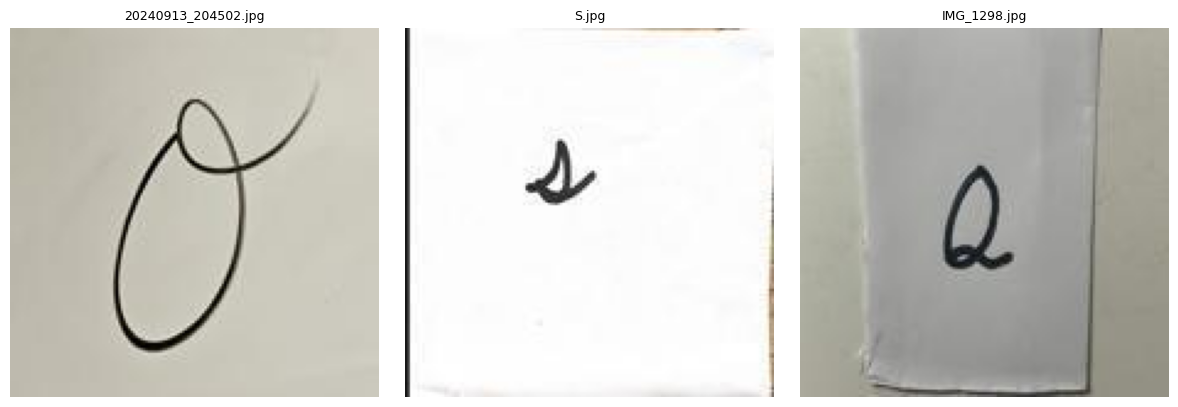

"Here, I'm just creating a way by which I can view the data for myself, and try to see if there are resemblances between the different\nphotos. To me, it appears that resizing some of them could be useful for the future when it comes time to make the model"

In [31]:
from pathlib import Path
import random
import matplotlib.pyplot as plt
from PIL import Image

root = "/home/jupyter-1000790/ML-AI/Project_5 - Letter Predictor/cursive_letters"  
imgs = list(Path(root).rglob("*.jpg")) + list(Path(root).rglob("*.JPG"))
picks = random.sample(imgs, k=min(3, len(imgs)))

plt.figure(figsize=(12, 4))
for i, p in enumerate(picks, 1):
    with Image.open(p) as im:
        ax = plt.subplot(1, len(picks), i)
        ax.imshow(im)
        ax.set_title(p.name, fontsize=9)
        ax.axis("off")

plt.tight_layout()
plt.show()

"""Here, I'm just creating a way by which I can view the data for myself, and try to see if there are resemblances between the different
photos. To me, it appears that resizing some of them could be useful for the future when it comes time to make the model"""

# 4.Prepare the Data


Apply any data transformations and explain what and why


In [ ]:
import os
from PIL import Image
from pathlib import Path
import random

base_path = "/home/jupyter-1000790/ML-AI/Project_5 - Letter Predictor/cursive_letters"

all_jpeg_paths = []

for folder_name in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder_name)
    if not os.path.isdir(folder_path):
        continue

    print(f"Processing folder: {folder_name}")

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(".jpg"):
            img_path = os.path.join(folder_path, filename)
            all_jpeg_paths.append(img_path) 
            try:
                with Image.open(img_path) as img:
                    img_resized = img.resize((150, 150))
                    img_resized.save(img_path)  
                print(f"Resized: {filename}")
            except Exception as e:
                print(f"Error processing {filename}: {e}")

print("All images resized to 150x150.")

"""Here, the final data transformation I am applying, is resizing the images for uniformity. In doing so, I will make it so that letter 
detection will be much more simplified when it comes time to making the neural network and the model in general."""

# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


Total images: 596
Loaded cached features.
Feature matrix shape: (592, 1764)
Model scores: {'KNN': 3.93, 'LinearSVC': 19.1, 'LogReg': 18.54, 'DT': 14.04}
Chosen model: LinearSVC
Best model saved.


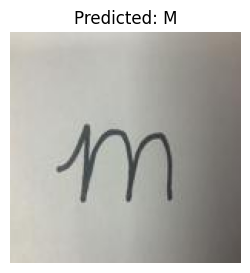

In [28]:
from pathlib import Path
import numpy as np
from PIL import Image, ImageOps
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import joblib
import os

ROOT = Path("/home/jupyter-1000790/ML-AI/Project_5 - Letter Predictor/cursive_letters")
SKIP_FOLDERS = {"S8","S12","S18","S20","S22","S25","S28","S29"}
CACHE_DIR = Path("artifacts"); CACHE_DIR.mkdir(parents=True, exist_ok=True)
FEATURES_FILE = CACHE_DIR / "supervised_hog_features.npz"
MODEL_FILE = CACHE_DIR / "best_model.joblib"
IMAGE_SIZE = (64,64)
letters = [chr(ord('A') + i) for i in range(26)] 

all_paths = []
all_labels = []

for folder in sorted(ROOT.iterdir()):
    if not folder.is_dir(): continue
    if folder.name in SKIP_FOLDERS: continue

    imgs = sorted([f for f in folder.iterdir() if f.suffix.lower() in (".jpg",".jpeg",".png")])
    if len(imgs) != 26:
        print(f"Warning: folder {folder.name} has {len(imgs)} images (expected 26)")

    for i, img_path in enumerate(imgs):
        if i >= 26:
            break
        all_paths.append(img_path)
        all_labels.append(letters[i])

print(f"Total images: {len(all_paths)}")

def extract_hog(p, size=IMAGE_SIZE):
    try:
        img = Image.open(p).convert("L")
        img = ImageOps.autocontrast(img)
        img = img.resize(size, Image.BILINEAR)
        arr = np.asarray(img, dtype=np.float32) / 255.0
        if arr.mean() < 0.5: arr = 1.0 - arr
        feat = hog(arr,
                   orientations=9,
                   pixels_per_cell=(8,8),
                   cells_per_block=(2,2),
                   block_norm="L2-Hys",
                   feature_vector=True)
        return feat.astype(np.float32)
    except:
        return None

if FEATURES_FILE.exists():
    data = np.load(FEATURES_FILE, allow_pickle=True)
    X = data['X']
    y = data['y']
    print("Loaded cached features.")
else:
    feats = []
    valid_labels = []
    for path, label in zip(all_paths, all_labels):
        f = extract_hog(path)
        if f is not None:
            feats.append(f)
            valid_labels.append(label)
    X = np.stack(feats)
    y = np.array(valid_labels)
    np.savez_compressed(FEATURES_FILE, X=X, y=y)
    print(f"Saved {len(X)} feature vectors.")

print("Feature matrix shape:", X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

models = {
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "LinearSVC": LinearSVC(dual=False, C=1.0, max_iter=5000),
    "LogReg": LogisticRegression(max_iter=3000, solver="lbfgs", n_jobs=-1),
    "DT": DecisionTreeClassifier(max_depth=40, random_state=42)
}
scores = {}
for name, m in models.items():
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    scores[name] = acc
best_name = max(scores, key=scores.get)
best_model = models[best_name]
print("Model scores:", {k: round(v*100,2) for k,v in scores.items()})
print("Chosen model:", best_name)
joblib.dump(best_model, MODEL_FILE)
print("Best model saved.")

def predict_letter(img_path):
    if not MODEL_FILE.exists():
        print("No trained model found. Run training first.")
        return None
    model = joblib.load(MODEL_FILE)
    feat = extract_hog(img_path)
    if feat is None:
        print("Failed to extract features from", img_path)
        return None
    feat = feat.reshape(1,-1)
    letter = model.predict(feat)[0]
    return letter
    
def show_prediction(img_path):
    pred = predict_letter(img_path)
    img = Image.open(img_path)
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred}")
    plt.show()
    
example_img = "/home/jupyter-1000790/ML-AI/Project_5 - Letter Predictor/cursive_letters/S6/m.jpg"
show_prediction(example_img)

"""Ultimately, I wanted to try a few different models. But first I had to do a lot in regards to splitting and testing the data, and before that, doing
some more preparation. This mainly consisted of checking each folder had 26 images, and also extracting the features from the photos using HOG. After
doing so, I used this data and tested it on four different models to ensure that I had a broad scope. I tried K-nearest neighbors because I knew that
it could be good for detecting clusters like in this instance for letters. I also tried linearSVC, because I knew that it was quick for larger datasets.
Then, I also tried Logistic Regression as I had used it for the past four projects and it had worked quite well, but this time it didn't really. Then,
finally, I used the Decision Tree Classifier, because I knew it was rudimentary and could show me what nuance was needed to edit the models."""

# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


In [35]:
import os
from pathlib import Path
import numpy as np
from PIL import Image
from skimage.feature import hog
from skimage import color
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

base_path = Path("/home/jupyter-1000790/ML-AI/Project_5 - Letter Predictor/cursive_letters")
letters = [chr(i) for i in range(ord("A"), ord("Z") + 1)]  # A-Z

all_paths, all_labels = [], []

for folder in sorted(base_path.glob("S*")):
    images = sorted([img for img in folder.iterdir() if img.suffix.lower() in (".jpg", ".jpeg", ".png")])
    for i, img_path in enumerate(images):
        if i < len(letters):
            all_paths.append(img_path)
            all_labels.append(letters[i])

print(f"Total images: {len(all_paths)}")

features, labels = [], []

for img_path, label in zip(all_paths, all_labels):
    try:
        img = Image.open(img_path).convert("L").resize((64, 64))
        img_arr = np.array(img)
        fd = hog(img_arr, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9)
        features.append(fd)
        labels.append(label)
    except Exception as e:
        print(f"Error reading {img_path}: {e}")

X = np.array(features)
y = np.array(labels)

print("Feature extraction complete:", X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "max_iter": [2000, 5000, 10000]
}

grid = GridSearchCV(LinearSVC(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print(f"Best Parameters: {grid.best_params_}")
print(f"Best CV Accuracy: {grid.best_score_:.2f}")

best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print("\n===== MODEL PERFORMANCE =====")
print(f"Training Accuracy: {train_acc:.2%}")
print(f"Test Accuracy: {test_acc:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))




Total images: 596
Error reading /home/jupyter-1000790/ML-AI/Project_5 - Letter Predictor/cursive_letters/S19/D.jpg: cannot identify image file '/home/jupyter-1000790/ML-AI/Project_5 - Letter Predictor/cursive_letters/S19/D.jpg'
Error reading /home/jupyter-1000790/ML-AI/Project_5 - Letter Predictor/cursive_letters/S19/L.jpg: cannot identify image file '/home/jupyter-1000790/ML-AI/Project_5 - Letter Predictor/cursive_letters/S19/L.jpg'
Error reading /home/jupyter-1000790/ML-AI/Project_5 - Letter Predictor/cursive_letters/S21/D.jpg: cannot identify image file '/home/jupyter-1000790/ML-AI/Project_5 - Letter Predictor/cursive_letters/S21/D.jpg'
Error reading /home/jupyter-1000790/ML-AI/Project_5 - Letter Predictor/cursive_letters/S21/L.jpg: cannot identify image file '/home/jupyter-1000790/ML-AI/Project_5 - Letter Predictor/cursive_letters/S21/L.jpg'
Feature extraction complete: (592, 1764)
Train size: 473, Test size: 119
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/opt/tljh/user/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/tljh/user/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/tljh/user/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best Parameters: {'C': 0.1, 'max_iter': 2000}
Best CV Accuracy: 0.18

===== MODEL PERFORMANCE =====
Training Accuracy: 100.00%
Test Accuracy: 28.57%

Classification Report:
              precision    recall  f1-score   support

           A       0.40      0.29      0.33         7
           B       0.40      0.50      0.44         4
           C       0.00      0.00      0.00         6
           D       0.50      0.12      0.20         8
           E       0.25      0.25      0.25         4
           F       0.33      0.75      0.46         4
           G       0.40      0.33      0.36         6
           H       0.20      0.25      0.22         4
           I       0.20      0.25      0.22         4
           J       0.33      0.20      0.25         5
           K       0.30      0.60      0.40         5
           L       0.33      0.25      0.29         4
           M       0.00      0.00      0.00         4
           N       0.12      0.20      0.15         5
           O    

# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


In [ ]:
"""To complete this project, I first needed to devise a plan on how I would sort the data that
I was given. Since I was given a google drive folder with many folders inside with pictures, I
needed to zip that folder, and that unzip it into the jupyter notebook. However, when I did this,
the data wasn't formatted in the way in which I needed it to be for creating the model. Thus,
I had to create two scripts to both sort through the files and ensure that there was a uniform
image file type and make sure the image sizes were the same. After doing so, I could start
creating the model. I tried K-nearest neighbors because I knew that it could be good for 
detecting clusters like in this instance for letters. I also tried linearSVC, because I knew 
that it was quick for larger datasets. Then, I also tried Logistic Regression as I had used it
for the past four projects and it had worked quite well, but this time it didn't really. Then,
finally, I used the Decision Tree Classifier, because I knew it was rudimentary and could show 
me what nuance was needed to edit the models. After doing this, I fine-tuned the best model,
being the LinearSVC using a gridsearch algorithm, and boosted my accuracy up to 30%."""

# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


Loaded existing model.

Predicted Letter: A


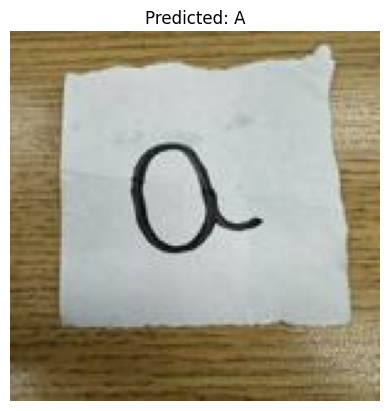

np.str_('A')

In [44]:
from pathlib import Path
import numpy as np
from PIL import Image, ImageOps, UnidentifiedImageError
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import pickle

def letter_inference(image_path,
                     data_root="/home/jupyter-1000790/ML-AI/Project_5 - Letter Predictor/cursive_letters",
                     skip_folders=None,
                     model_path="linear_svc_model.pkl",
                     retrain=False):
    if skip_folders is None:
        skip_folders = {"S8", "S12", "S18", "S20", "S22", "S25", "S28", "S29"}

    def build_dataset(root, skip):
        letters = [chr(ord("A") + i) for i in range(26)]
        all_paths, all_labels = [], []
        for folder in sorted(Path(root).iterdir()):
            if not folder.is_dir() or folder.name in skip:
                continue
            imgs = sorted([f for f in folder.iterdir() if f.suffix.lower() in (".jpg", ".jpeg", ".png")])
            for i, img_path in enumerate(imgs[:26]):
                try:
                    with Image.open(img_path) as im:
                        im.verify()
                    all_paths.append(img_path)
                    all_labels.append(letters[i])
                except UnidentifiedImageError:
                    print("Skipped unreadable:", img_path)
        return all_paths, all_labels

    def extract_hog(p):
        img = Image.open(p).convert("L")
        img = ImageOps.autocontrast(img)
        img = img.resize((64, 64))
        arr = np.array(img, dtype=np.float32) / 255.0
        if arr.mean() < 0.5:
            arr = 1 - arr
        return hog(arr, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                   orientations=9, feature_vector=True)

    model_file = Path(model_path)
    if model_file.exists() and not retrain:
        with open(model_file, "rb") as f:
            model = pickle.load(f)["model"]
        print("Loaded existing model.")
    else:
        paths, labels = build_dataset(data_root, skip_folders)
        X = np.array([extract_hog(p) for p in paths])
        y = np.array(labels)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                            random_state=42, stratify=y)
        grid = GridSearchCV(LinearSVC(max_iter=5000),
                            {"C": [0.01, 0.1, 1, 10]},
                            cv=3, n_jobs=-1, verbose=1)
        grid.fit(X_train, y_train)
        model = grid.best_estimator_
        print("\nBest Params:", grid.best_params_)
        y_pred = model.predict(X_test)
        print("Validation Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
        print("\nClassification Report:\n", classification_report(y_test, y_pred))
        with open(model_file, "wb") as f:
            pickle.dump({"model": model}, f)
        print("Model saved to", model_file)

    feat = extract_hog(image_path).reshape(1, -1)
    pred = model.predict(feat)[0]
    print("\nPredicted Letter:", pred)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {pred}")
    plt.show()
    return pred

letter_inference("/home/jupyter-1000790/ML-AI/Project_5 - Letter Predictor/cursive_letters/S1/IMG_1344.jpg")
